In [53]:
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
import torch.nn.functional as F

from transformers import AutoTokenizer, AutoModelForMaskedLM

import numpy as np
import pandas as pd

from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, f1_score, precision_score, recall_score

import math
import json
import operator

import matplotlib.pyplot as plt
import seaborn as sns
    
import warnings
warnings.filterwarnings('ignore')
plt.rcParams['font.sans-serif'] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False

In [2]:
with open('train.json', 'r', encoding='utf8') as f:
    df = json.load(f)

In [3]:
df

[{'id': '4-47',
  'wrong_ids': [16, 29, 30, 43],
  'original_text': '220千伏东沽港站、三圣口站、杨分港站、滩里站、祖寺站、新镉渣、广安站、张庄站共8座变店站全停',
  'correct_text': '220千伏东沽港站、三圣口站、杨芬港站、滩里站、祖寺站、新镇站、广安站、张庄站共8座变电站全停'},
 {'id': '4-45',
  'wrong_ids': [1, 8, 17, 23],
  'original_text': '总界经验：硅橡胶完高分子聚合物聚二申基硅醚同有几过氧化合物进行交链而成，主链由硅氧键构成。',
  'correct_text': '总结经验：硅橡胶由高分子聚合物聚二甲基硅醚同有机过氧化合物进行交链而成，主链由硅氧键构成。'},
 {'id': 'B2-3615-1',
  'original_text': '希望以后我的子孙还有机会看到我盖的这个大楼，也会留给他们好印像。',
  'wrong_ids': [30],
  'correct_text': '希望以后我的子孙还有机会看到我盖的这个大楼，也会留给他们好印象。'},
 {'id': 'A2-3893-1',
  'original_text': '晚上他跟一些同学一起去吃东西、唱歌。',
  'wrong_ids': [],
  'correct_text': '晚上他跟一些同学一起去吃东西、唱歌。'},
 {'id': '3-67',
  'wrong_ids': [20, 47, 65],
  'original_text': '5.万顺一回线停运时，切换装置A（B）对鹦的线路检修把手至线路检修位置。上述开关检修时，切换装直A（B）对应的开关检修把手至检修位遣。',
  'correct_text': '5.万顺一回线停运时，切换装置A（B）对应的线路检修把手至线路检修位置。上述开关检修时，切换装置A（B）对应的开关检修把手至检修位置。'},
 {'id': 'B2-4131-1',
  'original_text': '这样子不是波坏我们的「美丽环境」呢？我们怎么会有「建康」的地方？而且我们这里也很多（小孩）子，对他们真的不好吧！…',
  'wrong_ids': [5, 25],
  'c

In [4]:
data_set = []

for i in df:
    if len(i['wrong_ids']) > 0:
        data_set.append(i)

In [5]:
len(data_set)

1273

In [6]:
data_set

[{'id': '4-47',
  'wrong_ids': [16, 29, 30, 43],
  'original_text': '220千伏东沽港站、三圣口站、杨分港站、滩里站、祖寺站、新镉渣、广安站、张庄站共8座变店站全停',
  'correct_text': '220千伏东沽港站、三圣口站、杨芬港站、滩里站、祖寺站、新镇站、广安站、张庄站共8座变电站全停'},
 {'id': '4-45',
  'wrong_ids': [1, 8, 17, 23],
  'original_text': '总界经验：硅橡胶完高分子聚合物聚二申基硅醚同有几过氧化合物进行交链而成，主链由硅氧键构成。',
  'correct_text': '总结经验：硅橡胶由高分子聚合物聚二甲基硅醚同有机过氧化合物进行交链而成，主链由硅氧键构成。'},
 {'id': 'B2-3615-1',
  'original_text': '希望以后我的子孙还有机会看到我盖的这个大楼，也会留给他们好印像。',
  'wrong_ids': [30],
  'correct_text': '希望以后我的子孙还有机会看到我盖的这个大楼，也会留给他们好印象。'},
 {'id': '3-67',
  'wrong_ids': [20, 47, 65],
  'original_text': '5.万顺一回线停运时，切换装置A（B）对鹦的线路检修把手至线路检修位置。上述开关检修时，切换装直A（B）对应的开关检修把手至检修位遣。',
  'correct_text': '5.万顺一回线停运时，切换装置A（B）对应的线路检修把手至线路检修位置。上述开关检修时，切换装置A（B）对应的开关检修把手至检修位置。'},
 {'id': 'B2-4131-1',
  'original_text': '这样子不是波坏我们的「美丽环境」呢？我们怎么会有「建康」的地方？而且我们这里也很多（小孩）子，对他们真的不好吧！…',
  'wrong_ids': [5, 25],
  'correct_text': '这样子不是破坏我们的「美丽环境」呢？我们怎么会有「健康」的地方？而且我们这里也很多（小孩）子，对他们真的不好吧！…'},
 {'id': 'B2-4361-4',
  'original_text': '在家说，装

In [7]:
x_train, x_test = train_test_split(data_set, test_size=.2)

In [8]:
len(x_train), len(x_test)

(1018, 255)

In [9]:
class DataCollator:
    def __init__(self, tokenizer):
        self.tokenizer = tokenizer

    def __call__(self, data):
        ori_texts, cor_texts, wrong_idss = zip(*data)
        encoded_texts = [self.tokenizer(t, return_offsets_mapping=True, add_special_tokens=False) for t in ori_texts]
        max_len = max([len(t['input_ids']) for t in encoded_texts]) + 2
        det_labels = torch.zeros(len(ori_texts), max_len).long()

        for i, (encoded_text, wrong_ids) in enumerate(zip(encoded_texts, wrong_idss)):
            off_mapping = encoded_text['offset_mapping']
            for idx in wrong_ids:
                for j, (b, e) in enumerate(off_mapping):
                    if b <= idx < e:
                        # j+1是因为前面的 CLS token
                        det_labels[i, j + 1] = 1
                        break
        return list(ori_texts), list(cor_texts), det_labels

In [10]:
class CscDataset(Dataset):
    def __init__(self, data):
        self.data = data

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index):
        return self.data[index]['original_text'], self.data[index]['correct_text'], self.data[index]['wrong_ids']

In [11]:
def make_loaders(
        collate_fn, train_data, test_data,
        batch_size=32, num_workers=0
):
    train_loader = DataLoader(
        CscDataset(train_data),
        batch_size=batch_size,
        shuffle=True,
        num_workers=num_workers,
        collate_fn=collate_fn
    )
    test_loader = DataLoader(
        CscDataset(test_data),
        batch_size=batch_size,
        shuffle=False,
        num_workers=num_workers,
        collate_fn=collate_fn
    )

    return train_loader, test_loader

In [12]:
model_path = 'shibing624/macbert4csc-base-chinese'

In [13]:
tokenizer = AutoTokenizer.from_pretrained(model_path)

In [14]:
collator = DataCollator(tokenizer=tokenizer)
# 加载数据
train_loader, test_loader = make_loaders(
    collator, train_data=x_train, test_data=x_test,
    batch_size=12, num_workers=0
)

In [15]:
# text, cor_labels, det_labels = next(iter(train_loader))

In [16]:
model = AutoModelForMaskedLM.from_pretrained(model_path)

In [17]:
class FocalLoss(nn.Module):
    def __init__(self, num_labels, activation_type='softmax', gamma=2.0, alpha=0.25, epsilon=1.e-9):
        super(FocalLoss, self).__init__()
        self.num_labels = num_labels
        self.gamma = gamma
        self.alpha = alpha
        self.epsilon = epsilon
        self.activation_type = activation_type

    def forward(self, input, target):
        """
        Args:
            logits: model's output, shape of [batch_size, num_cls]
            target: ground truth labels, shape of [batch_size]
        Returns:
            shape of [batch_size]
        """
        if self.activation_type == 'softmax':
            idx = target.view(-1, 1).long()
            one_hot_key = torch.zeros(idx.size(0), self.num_labels, dtype=torch.float32, device=idx.device)
            one_hot_key = one_hot_key.scatter_(1, idx, 1)
            logits = torch.softmax(input, dim=-1)
            loss = -self.alpha * one_hot_key * torch.pow((1 - logits), self.gamma) * (logits + self.epsilon).log()
            loss = loss.sum(1)
        elif self.activation_type == 'sigmoid':
            multi_hot_key = target
            logits = torch.sigmoid(input)
            zero_hot_key = 1 - multi_hot_key
            loss = -self.alpha * multi_hot_key * torch.pow((1 - logits), self.gamma) * (logits + self.epsilon).log()
            loss += -(1 - self.alpha) * zero_hot_key * torch.pow(logits, self.gamma) * (1 - logits + self.epsilon).log()
        return loss.mean()

In [18]:
base_model = AutoModelForMaskedLM.from_pretrained('hfl/chinese-macbert-base')

Some weights of the model checkpoint at hfl/chinese-macbert-base were not used when initializing BertForMaskedLM: ['cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [19]:
class CscModel(nn.Module):
    def __init__(self, tokenizer, device):
        super(CscModel, self).__init__()
        self.bert = base_model
        self.detection = nn.Linear(self.bert.config.hidden_size, 1)
        self.sigmoid = nn.Sigmoid()
        self.tokenizer = tokenizer
        self.device = device

    def forward(self, texts, cor_labels=None, det_labels=None):
        if cor_labels:
            text_labels = self.tokenizer(cor_labels, padding=True, return_tensors='pt')['input_ids']
            text_labels[text_labels == 0] = -100  # -100计算损失时会忽略
            text_labels = text_labels.to(self.device)
        else:
            text_labels = None

        encoded_text = self.tokenizer(texts, padding=True, return_tensors='pt').to(self.device)
        bert_outputs = self.bert(**encoded_text, labels=text_labels, return_dict=True, output_hidden_states=True)
        # 检错概率
        prob = self.detection(bert_outputs.hidden_states[-1])

        if text_labels is None:
            # 检错输出，纠错输出
            outputs = (
                prob, bert_outputs.logits
            )
        else:
            det_loss_fct = FocalLoss(num_labels=None, activation_type='sigmoid')
            # pad部分不计算损失
            active_loss = encoded_text['attention_mask'].view(-1, prob.shape[1]) == 1
            active_probs = prob.view(-1, prob.shape[1])[active_loss]
            active_labels = det_labels.to(self.device)[active_loss]
            det_loss = det_loss_fct(active_probs, active_labels.float())
            # 检错loss，纠错loss，检错输出，纠错输出
            outputs = (
                det_loss,
                bert_outputs.loss,
                self.sigmoid(prob).squeeze(-1),
                bert_outputs.logits
            )
        return outputs

In [20]:
learning_rate = 3e-5  # 学习率
epochs = 3

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [21]:
csc_model = CscModel(tokenizer=tokenizer, device=device)
csc_model.to(device)

CscModel(
  (bert): BertForMaskedLM(
    (bert): BertModel(
      (embeddings): BertEmbeddings(
        (word_embeddings): Embedding(21128, 768, padding_idx=0)
        (position_embeddings): Embedding(512, 768)
        (token_type_embeddings): Embedding(2, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): BertEncoder(
        (layer): ModuleList(
          (0): BertLayer(
            (attention): BertAttention(
              (self): BertSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): BertSelfOutput(
                (dense): Linear(in_features=768, out_features=768, bias=True)
                (

In [22]:
# 构建权重
load_parameters = csc_model.state_dict()
for k, v in model.named_parameters():
    if 'bert.' + k in csc_model.state_dict().keys():
        load_parameters['bert.' + k] = v

In [23]:
# 加载权重
csc_model.load_state_dict(load_parameters)

<All keys matched successfully>

In [24]:
for k, v in csc_model.named_parameters():
    v.requires_grad = True

In [25]:
for k, v in csc_model.named_parameters():
    print(k, v.requires_grad)

bert.bert.embeddings.word_embeddings.weight True
bert.bert.embeddings.position_embeddings.weight True
bert.bert.embeddings.token_type_embeddings.weight True
bert.bert.embeddings.LayerNorm.weight True
bert.bert.embeddings.LayerNorm.bias True
bert.bert.encoder.layer.0.attention.self.query.weight True
bert.bert.encoder.layer.0.attention.self.query.bias True
bert.bert.encoder.layer.0.attention.self.key.weight True
bert.bert.encoder.layer.0.attention.self.key.bias True
bert.bert.encoder.layer.0.attention.self.value.weight True
bert.bert.encoder.layer.0.attention.self.value.bias True
bert.bert.encoder.layer.0.attention.output.dense.weight True
bert.bert.encoder.layer.0.attention.output.dense.bias True
bert.bert.encoder.layer.0.attention.output.LayerNorm.weight True
bert.bert.encoder.layer.0.attention.output.LayerNorm.bias True
bert.bert.encoder.layer.0.intermediate.dense.weight True
bert.bert.encoder.layer.0.intermediate.dense.bias True
bert.bert.encoder.layer.0.output.dense.weight True
bert

In [26]:
# 句粒度Acc
def calc_metrics(logits, cor_content):
    pre = []
    predict_list = []
    true_list = []
    for k, v in zip(cor_content, logits):
        _text = tokenizer.decode(torch.argmax(v, dim=-1), skip_special_tokens=True).replace(' ', '')
        corrected_text = _text[:len(k)]
        
        tk1 = tokenizer([corrected_text], add_special_tokens=True)['input_ids'][0]
        tk2 = tokenizer([k], add_special_tokens=True)['input_ids'][0]
        
        max_len = max(len(tk1), len(tk2))
        
        predict_list += tk1 + [tokenizer.pad_token_id] * (max_len - len(tk1))
        true_list += tk2 + [tokenizer.pad_token_id] * (max_len - len(tk2))
        
        pre.append(corrected_text)
    return accuracy_score(true_list, predict_list), cor_labels, pre

In [27]:
optimizer = torch.optim.Adam(csc_model.parameters(), lr=learning_rate, betas=(0.9, 0.98), eps=1e-9)
transformer_optimizer = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer=optimizer, T_max=epochs) #  调整了四分之一周期的长度

In [28]:
# 训练模型
total_train_loss_list = []
total_train_acc_score_list = []

total_test_loss_list = []
total_test_acc_score_list = []
for epoch in range(1, epochs + 1):
    train_loss_list = []
    train_acc_score_list = []
    
    test_loss_list = []
    test_acc_score_list = []
    
    model.train()
    for text, cor_labels, det_labels in train_loader:
        optimizer.zero_grad()
        
        out = csc_model(text, cor_labels, det_labels)
        
        loss = out[0] * 0.7 + out[1] * 0.3
        loss.backward()
        
        optimizer.step()
        
        true = cor_labels
        predic = out[-1].cpu()
        acc_score = calc_metrics(predic, true)[0]
        
        train_loss_list.append(loss.item())
        train_acc_score_list.append(acc_score)
        transformer_optimizer.step()
        
    model.eval()
    with torch.no_grad():
        for text, cor_labels, det_labels in test_loader:
            out = csc_model(text, cor_labels, det_labels)
            
            loss = out[0] * 0.7 + out[1] * 0.3
            
            true = cor_labels
            predic = out[-1].cpu()
            acc_score = calc_metrics(predic, true)[0]

            test_loss_list.append(loss.item())
            test_acc_score_list.append(acc_score)
        
    print("epoch: %3d, train loss: %6.3f, train ACC: %2.4f, test loss: %6.3f, test ACC: %2.4f\n"% (
        epoch, np.mean(train_loss_list), np.mean(train_acc_score_list),
        np.mean(test_loss_list), np.mean(test_acc_score_list)
    ))
    
    total_train_loss_list.append(np.mean(train_loss_list))
    total_train_acc_score_list.append(np.mean(train_acc_score_list))
    
    total_test_loss_list.append(np.mean(test_loss_list))
    total_test_acc_score_list.append(np.mean(test_acc_score_list))

epoch:   1, train loss:  0.087, train ACC: 0.9211, test loss:  0.066, test ACC: 0.9182

epoch:   2, train loss:  0.038, train ACC: 0.9417, test loss:  0.063, test ACC: 0.9240

epoch:   3, train loss:  0.020, train ACC: 0.9531, test loss:  0.067, test ACC: 0.9230



Text(0.5, 1.0, 'Loss')

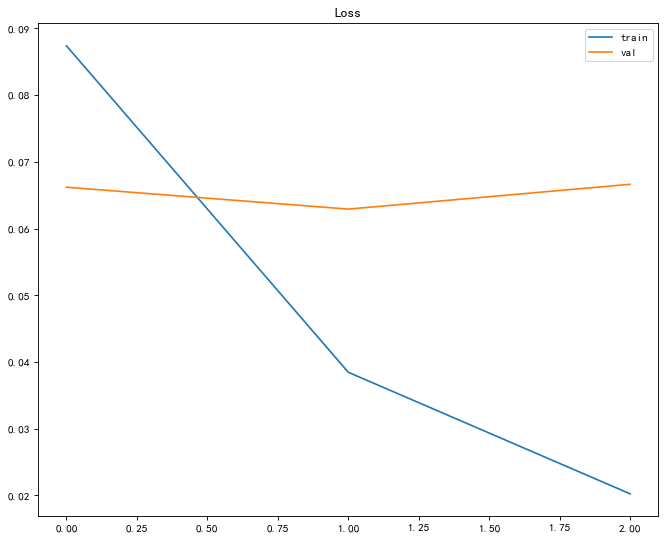

In [29]:
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(total_train_loss_list, label='train')
plt.plot(total_test_loss_list, label='val')
plt.legend()
plt.title('Loss')

Text(0.5, 1.0, 'ACC')

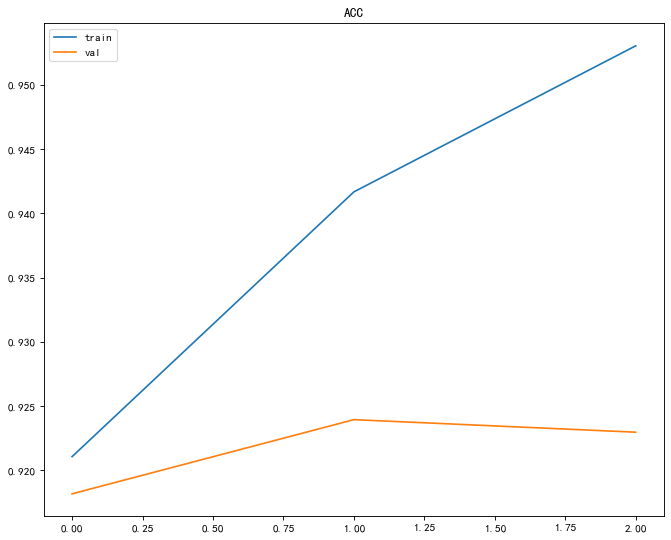

In [30]:
plt.figure(figsize=(10, 8), dpi=80)
plt.plot(total_train_acc_score_list, label='train')
plt.plot(total_test_acc_score_list, label='val')
plt.legend()
plt.title('ACC')

In [31]:
pre = []
y_true = []
acc_list = []
# 验证集进行预测
with torch.no_grad():
    for text, cor_labels, det_labels in test_loader:
        out = csc_model(text, cor_labels, det_labels)

        true = cor_labels
        predic = out[-1].cpu()
        acc_score, true, predic = calc_metrics(predic, true)
        
        pre += predic
        y_true += true
        acc_list += [acc_score]

In [32]:
# 词粒度ACC
np.mean(acc_list)

0.9229791581050865

In [33]:
# 句粒度Acc
accuracy_score(y_true, pre)

0.40784313725490196

In [45]:
predict_list = []
true_list = []

for k, v in zip(y_true, pre):
    l1 = len(k)
    l2 = len(v)
    
    max_len = max(l1, l2)
    
    true_list += list(k) + [tokenizer.pad_token] * (max_len - l1)
    predict_list += list(v) + [tokenizer.pad_token] * (max_len - l2)

In [48]:
accuracy_score(true_list, predict_list)

0.9012631204412026


In [51]:
precision_score(true_list, predict_list, average='micro')

0.9012631204412026

In [54]:
recall_score(true_list, predict_list, average='micro')

0.9012631204412026

In [52]:
f1_score(true_list, predict_list, average='micro')

0.9012631204412025

In [34]:
df

[{'id': '4-47',
  'wrong_ids': [16, 29, 30, 43],
  'original_text': '220千伏东沽港站、三圣口站、杨分港站、滩里站、祖寺站、新镉渣、广安站、张庄站共8座变店站全停',
  'correct_text': '220千伏东沽港站、三圣口站、杨芬港站、滩里站、祖寺站、新镇站、广安站、张庄站共8座变电站全停'},
 {'id': '4-45',
  'wrong_ids': [1, 8, 17, 23],
  'original_text': '总界经验：硅橡胶完高分子聚合物聚二申基硅醚同有几过氧化合物进行交链而成，主链由硅氧键构成。',
  'correct_text': '总结经验：硅橡胶由高分子聚合物聚二甲基硅醚同有机过氧化合物进行交链而成，主链由硅氧键构成。'},
 {'id': 'B2-3615-1',
  'original_text': '希望以后我的子孙还有机会看到我盖的这个大楼，也会留给他们好印像。',
  'wrong_ids': [30],
  'correct_text': '希望以后我的子孙还有机会看到我盖的这个大楼，也会留给他们好印象。'},
 {'id': 'A2-3893-1',
  'original_text': '晚上他跟一些同学一起去吃东西、唱歌。',
  'wrong_ids': [],
  'correct_text': '晚上他跟一些同学一起去吃东西、唱歌。'},
 {'id': '3-67',
  'wrong_ids': [20, 47, 65],
  'original_text': '5.万顺一回线停运时，切换装置A（B）对鹦的线路检修把手至线路检修位置。上述开关检修时，切换装直A（B）对应的开关检修把手至检修位遣。',
  'correct_text': '5.万顺一回线停运时，切换装置A（B）对应的线路检修把手至线路检修位置。上述开关检修时，切换装置A（B）对应的开关检修把手至检修位置。'},
 {'id': 'B2-4131-1',
  'original_text': '这样子不是波坏我们的「美丽环境」呢？我们怎么会有「建康」的地方？而且我们这里也很多（小孩）子，对他们真的不好吧！…',
  'wrong_ids': [5, 25],
  'c

In [35]:
def get_errors(corrected_text, origin_text):
    sub_details = []
    for i, ori_char in enumerate(origin_text):
        if ori_char in [' ', '“', '”', '‘', '’', '琊', '\n', '…', '—', '擤']:
            # add unk word
            corrected_text = corrected_text[:i] + ori_char + corrected_text[i:]
            continue
        if i >= len(corrected_text):
            continue
        if ori_char != corrected_text[i]:
            if ori_char.lower() == corrected_text[i]:
                # pass english upper char
                corrected_text = corrected_text[:i] + ori_char + corrected_text[i + 1:]
                continue
            sub_details.append((ori_char, corrected_text[i], i, i + 1))
    sub_details = sorted(sub_details, key=operator.itemgetter(2))
    return corrected_text, sub_details

In [36]:
test = ['220千伏东沽港站、三圣口站、杨分港站、滩里站、祖寺站、新镉渣、广安站、张庄站共8座变店站全停']

In [37]:
with torch.no_grad():
    outputs = csc_model(test)

In [38]:
result = []
for ids, text in zip(outputs[-1], test):
    _text = tokenizer.decode(torch.argmax(ids, dim=-1), skip_special_tokens=True).replace(' ', '')
    corrected_text = _text[:len(text)]
    corrected_text, details = get_errors(corrected_text, text)
    print(text, ' => ', corrected_text, details)
    result.append((corrected_text, details))

220千伏东沽港站、三圣口站、杨分港站、滩里站、祖寺站、新镉渣、广安站、张庄站共8座变店站全停  =>  220千伏东沽港站、三圣口站、杨芬港站、滩里站、祖寺站、新镇站、广安站、张庄站共8座变电站全停 [('分', '芬', 16, 17), ('镉', '镇', 29, 30), ('渣', '站', 30, 31), ('店', '电', 43, 44)]


In [39]:
torch.save(csc_model.state_dict(), 'model.pt')